<a href="https://colab.research.google.com/github/Danh1905/Scalable-Project/blob/main/scalableProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To upload a file from your local system, you can use `google.colab.files.upload()`:

In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving Customer-Churn-Prediction.csv to Customer-Churn-Prediction.csv
User uploaded file "Customer-Churn-Prediction.csv" with length 977501 bytes


Install pyspark


In [2]:
!pip install pyspark py4j

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Read CSV").getOrCreate()
churn_rate = spark.read.csv("/content/Customer-Churn-Prediction.csv", header=True, inferSchema=True)
churn_rate.printSchema()


root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



**Preprocessing**

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, sum, when, trim, lit

#Drop the useless ID
churn_rate = churn_rate.drop("customerID")

# Fix TotalCharges (Convert String to Number)
# Replace empty strings with nulls first, then cast to Double, and fill actual nulls with 0
churn_rate = churn_rate.withColumn("TotalCharges",
                                   when(trim(col("TotalCharges")) == "", lit(None)).otherwise(col("TotalCharges")))
churn_rate = churn_rate.withColumn("TotalCharges", col("TotalCharges").cast(DoubleType()))
churn_rate = churn_rate.fillna(0, subset=["TotalCharges"])

# Check null values
def count_nulls(churn_rate):
    null_counts = churn_rate.select([
        sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in churn_rate.columns
    ])
    return null_counts

null_churn_rate = count_nulls(churn_rate)
null_churn_rate.show()

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|           0|   

In [5]:
# ENCODE ALL TEXT COLUMNS

# List of columns that are text (categorical) and need to be numbers
# Note: I excluded 'Churn' because we handle it separately as the label
categorical_cols = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod"
]

# This loop converts each text column into a number column
# Example: "gender" becomes "gender_index" (0 or 1)
indexers = []
for column in categorical_cols:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    churn_rate = indexer.fit(churn_rate).transform(churn_rate)

# Don't forget to encode the Target variable (Churn) too!
label_indexer = StringIndexer(inputCol="Churn", outputCol="label")
churn_rate = label_indexer.fit(churn_rate).transform(churn_rate)



In [6]:
# ASSEMBLE

# Gather all the NEW numbered columns + the original numerical columns
input_features = [c + "_index" for c in categorical_cols] + \
                 ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]

# Squash them into one vector
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
final_data = assembler.transform(churn_rate)

# Show the result
final_data.select("features", "label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(19,[0,1,3,4,5,7,...|  0.0|
|(19,[5,6,8,12,13,...|  0.0|
|(19,[5,6,7,14,16,...|  1.0|
|[0.0,0.0,0.0,1.0,...|  0.0|
|(19,[0,16,17,18],...|  1.0|
+--------------------+-----+
only showing top 5 rows


In [7]:
from pyspark.ml.feature import StandardScaler

# SCALE THE FEATURES

scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                        withStd=True, withMean=False)

# Compute the scaling statistics
scalerModel = scaler.fit(final_data)

# Apply the scaling
data_ready = scalerModel.transform(final_data)

# Show the difference
data_ready.select("features", "scaled_features").show(5, truncate=False)

+-----------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                           |scaled_features                                                                                                                                                                                                                                                |
+-----------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Split data

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [9]:


# STEP 5: SPLIT DATA

#80% (train) & 20% (test)
train_data, test_data = data_ready.randomSplit([0.8, 0.2], seed=42)

print(f"Train: {train_data.count()}")
print(f"Test: {test_data.count()}")

Train: 5698
Test: 1345


In [10]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label")

In [11]:
lrm =lr.fit(train_data)

In [12]:
trainingSummary = lrm.summary

In [13]:
predictions = lrm.transform(test_data)

print("Result of prediction :")
predictions.select("prediction", "label", "probability").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of the Model : {accuracy:.2%}")

Result of prediction :
+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       1.0|  0.0|[0.43998226671737...|
|       1.0|  1.0|[0.38879493641823...|
|       0.0|  0.0|[0.64019648497660...|
|       0.0|  0.0|[0.58344828683453...|
|       0.0|  1.0|[0.57250268816098...|
+----------+-----+--------------------+
only showing top 5 rows
Accuracy of the Model : 80.74%


In [14]:
# Accuracy in train dataset
print(f"Accuracy: {trainingSummary.accuracy:.2%}")

# Area Under ROC (càng gần 1 càng tốt)
print(f"Area Under ROC: {trainingSummary.areaUnderROC:.4f}")

# FPR: False Positive Rate, TPR: True Positive Rate
print("ROC:")
trainingSummary.roc.show(5)

# Objective History
print("Objective History:")
for i, loss in enumerate(trainingSummary.objectiveHistory):
    print(f"Iteration {i}: {loss}")

Accuracy: 80.84%
Area Under ROC: 0.8430
ROC:
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0| 0.00333555703802535|
|                 0.0|  0.0066711140760507|
|2.381519409383186...|0.009339559706470981|
|2.381519409383186...|0.012675116744496331|
+--------------------+--------------------+
only showing top 5 rows
Objective History:
Iteration 0: 0.5762485159619298
Iteration 1: 0.5327361899350359
Iteration 2: 0.45399520952730466
Iteration 3: 0.4378860236276876
Iteration 4: 0.4324420932275601
Iteration 5: 0.4236087304550611
Iteration 6: 0.42196237200370273
Iteration 7: 0.4215173468459716
Iteration 8: 0.42115565106767644
Iteration 9: 0.420752534740688
Iteration 10: 0.4203338204634572
Iteration 11: 0.4194805358269721
Iteration 12: 0.41867967494528674
Iteration 13: 0.4178052349780378
Iteration 14: 0.41758867515712506
Iteration 15: 0.41757474381

In [15]:
#Confusion Matrix
print("Confusion Matrix:")
predictions.groupby('label', 'prediction').count().show()

Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  197|
|  0.0|       1.0|   86|
|  1.0|       0.0|  173|
|  0.0|       0.0|  889|
+-----+----------+-----+



In [16]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

predictions.select(
    "label",
    vector_to_array(col("probability"))[1].alias("p_churn"),
    "prediction"
).show(10)


+-----+-------------------+----------+
|label|            p_churn|prediction|
+-----+-------------------+----------+
|  0.0| 0.5600177332826282|       1.0|
|  1.0| 0.6112050635817676|       1.0|
|  0.0| 0.3598035150233997|       0.0|
|  0.0| 0.4165517131654668|       0.0|
|  1.0|0.42749731183901685|       0.0|
|  0.0|0.39763718747605514|       0.0|
|  0.0|0.41757401604325595|       0.0|
|  1.0|0.47864305129600904|       0.0|
|  0.0| 0.4060120442174221|       0.0|
|  1.0| 0.4027194709300088|       0.0|
+-----+-------------------+----------+
only showing top 10 rows


In [17]:
from pyspark.sql.functions import col

tp = predictions.filter(
    (col("label") == 1) & (col("prediction") == 1)
).count()

fn = predictions.filter(
    (col("label") == 1) & (col("prediction") == 0)
).count()

churn_recall_05 = tp / (tp + fn)

print(f"Churn Recall @ threshold=0.5: {churn_recall_05:.2%}")


Churn Recall @ threshold=0.5: 53.24%


Change threshold


In [18]:
from pyspark.sql.functions import when, col, lit
from pyspark.ml.functions import vector_to_array

THRESHOLD = 0.3

predictions_threshold = predictions.withColumn(
    "custom_prediction",
    when(vector_to_array(col("probability"))[1] >= THRESHOLD, lit(1.0)).otherwise(lit(0.0))
)


In [19]:
tp_new = predictions_threshold.filter(
    (col("label") == 1) & (col("custom_prediction") == 1)
).count()

fn_new = predictions_threshold.filter(
    (col("label") == 1) & (col("custom_prediction") == 0)
).count()

churn_recall_03 = tp_new / (tp_new + fn_new)

print(f"Churn Recall @ threshold={THRESHOLD}: {churn_recall_03:.2%}")


Churn Recall @ threshold=0.3: 76.49%


In [20]:
print(f"Confusion Matrix @ threshold = {THRESHOLD}")
predictions_threshold.groupby("label", "custom_prediction").count().show()


Confusion Matrix @ threshold = 0.3
+-----+-----------------+-----+
|label|custom_prediction|count|
+-----+-----------------+-----+
|  1.0|              1.0|  283|
|  0.0|              1.0|  211|
|  1.0|              0.0|   87|
|  0.0|              0.0|  764|
+-----+-----------------+-----+



In [21]:
print("Result of prediction with custom threshold:")
predictions_threshold.select("custom_prediction", "label", "probability").show(5)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="custom_prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions_threshold)
print(f"Accuracy of the Model with custom threshold : {accuracy:.2%}")

Result of prediction with custom threshold:
+-----------------+-----+--------------------+
|custom_prediction|label|         probability|
+-----------------+-----+--------------------+
|              1.0|  0.0|[0.43998226671737...|
|              1.0|  1.0|[0.38879493641823...|
|              1.0|  0.0|[0.64019648497660...|
|              1.0|  0.0|[0.58344828683453...|
|              1.0|  1.0|[0.57250268816098...|
+-----------------+-----+--------------------+
only showing top 5 rows
Accuracy of the Model with custom threshold : 77.84%


Compare Threshold


In [22]:
print("=== Threshold Comparison ===")
print(f"Recall churn @ 0.5 : {churn_recall_05:.2%}")
print(f"Recall churn @ 0.3 : {churn_recall_03:.2%}")


=== Threshold Comparison ===
Recall churn @ 0.5 : 53.24%
Recall churn @ 0.3 : 76.49%


Random Forest

In [23]:
from pyspark.ml.classification import RandomForestClassifier

print("Training Random Forest model")

rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,
    maxDepth=6,
    seed=42
)

rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)


Training Random Forest model


In [24]:
print("Random Forest Confusion Matrix @ threshold = 0.5")
rf_predictions.groupby("label", "prediction").count().show()


Random Forest Confusion Matrix @ threshold = 0.5
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  157|
|  0.0|       1.0|   75|
|  1.0|       0.0|  213|
|  0.0|       0.0|  900|
+-----+----------+-----+



In [25]:
from pyspark.sql.functions import col

tp_rf = rf_predictions.filter(
    (col("label") == 1) & (col("prediction") == 1)
).count()

fn_rf = rf_predictions.filter(
    (col("label") == 1) & (col("prediction") == 0)
).count()

rf_churn_recall_05 = tp_rf / (tp_rf + fn_rf)

print(f"Random Forest Churn Recall @ 0.5: {rf_churn_recall_05:.2%}")


Random Forest Churn Recall @ 0.5: 42.43%


In [26]:
from pyspark.sql.functions import when, col, lit
from pyspark.ml.functions import vector_to_array

THRESHOLD = 0.3

rf_predictions_threshold = rf_predictions.withColumn(
    "custom_prediction",
    when(vector_to_array(col("probability"))[1] >= THRESHOLD, lit(1.0)).otherwise(lit(0.0))
)


In [27]:
print(f"Random Forest Confusion Matrix @ threshold = {THRESHOLD}")
rf_predictions_threshold.groupby("label", "custom_prediction").count().show()


Random Forest Confusion Matrix @ threshold = 0.3
+-----+-----------------+-----+
|label|custom_prediction|count|
+-----+-----------------+-----+
|  1.0|              1.0|  275|
|  0.0|              1.0|  204|
|  1.0|              0.0|   95|
|  0.0|              0.0|  771|
+-----+-----------------+-----+



In [28]:
tp_rf_new = rf_predictions_threshold.filter(
    (col("label") == 1) & (col("custom_prediction") == 1)
).count()

fn_rf_new = rf_predictions_threshold.filter(
    (col("label") == 1) & (col("custom_prediction") == 0)
).count()

rf_churn_recall_03 = tp_rf_new / (tp_rf_new + fn_rf_new)

print(f"Random Forest Churn Recall @ 0.3: {rf_churn_recall_03:.2%}")


Random Forest Churn Recall @ 0.3: 74.32%


In [29]:
print("=== Churn Recall Comparison ===")
print(f"Logistic Regression @ 0.5 : {churn_recall_05:.2%}")
print(f"Logistic Regression @ 0.3 : {churn_recall_03:.2%}")
print(f"Random Forest @ 0.5      : {rf_churn_recall_05:.2%}")
print(f"Random Forest @ 0.3      : {rf_churn_recall_03:.2%}")


=== Churn Recall Comparison ===
Logistic Regression @ 0.5 : 53.24%
Logistic Regression @ 0.3 : 76.49%
Random Forest @ 0.5      : 42.43%
Random Forest @ 0.3      : 74.32%


Feature Importance

Top 10 Most Importance Feature:
                  Feature  Importance
12         Contract_index    0.209405
16                 tenure    0.194919
6    OnlineSecurity_index    0.126529
5   InternetService_index    0.100755
18           TotalCharges    0.086326
9       TechSupport_index    0.072797
17         MonthlyCharges    0.067775
14    PaymentMethod_index    0.062088
7      OnlineBackup_index    0.020589
10      StreamingTV_index    0.011501


/tmp/ipython-input-2287226022.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")


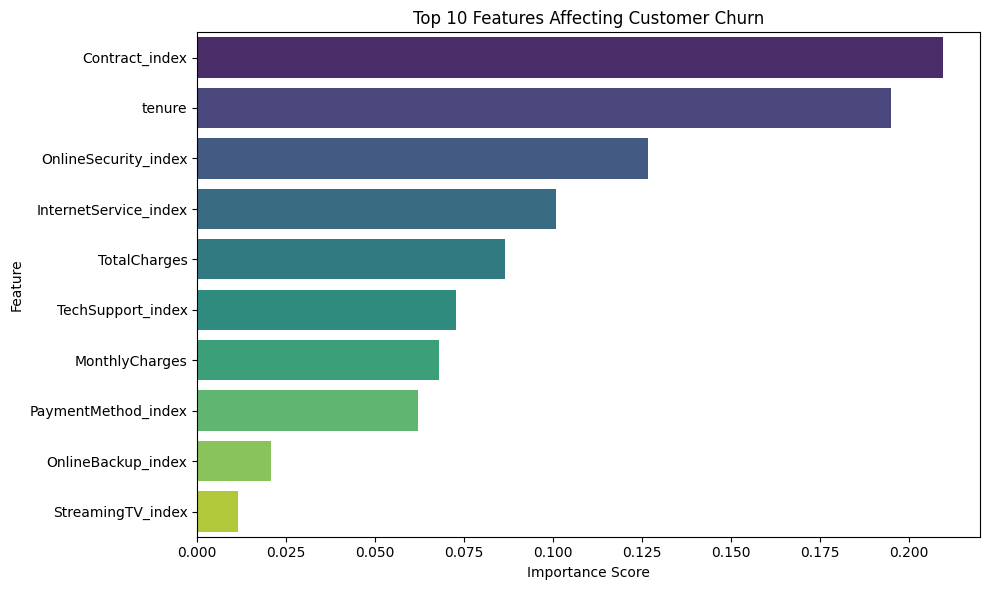

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


feature_names = input_features

# 2. Imporance value from Random Forest Model
importances = rf_model.featureImportances

# 3. Create dataframe
feature_importance_df = pd.DataFrame(list(zip(feature_names, importances)),
                                     columns=["Feature", "Importance"])

# 4. Ascending list
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# 5.top 10 most impotant feature
print("Top 10 Most Importance Feature:")
print(feature_importance_df.head(10))

# 6. Draw chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Features Affecting Customer Churn")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Hyperparameter Tuning

In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


print("--- Grid Search is Running  ---")

# Grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10])
             .addGrid(rf.numTrees, [10, 20])
             .build())

# Define the recall_evaluator
recall_evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")

# 2. Cross Validator
# numFolds=3
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=recall_evaluator, # Use the defined evaluator
                          numFolds=3)

# 3. Tuning (Fit)
cvModel = crossval.fit(train_data)

# 4. Champion Model
best_model = cvModel.bestModel

print("--- Grid Search Completed ---")

# 5.Result
best_predictions = best_model.transform(test_data)
best_recall = recall_evaluator.evaluate(best_predictions)

print(f"Recall of the model after Tuning: {best_recall:.2%}")

print(f"Best Max Depth: {best_model._java_obj.getMaxDepth()}")
print(f"Best Num Trees: {best_model._java_obj.getNumTrees()}")

--- Grid Search is Running  ---
--- Grid Search Completed ---
Recall of the model after Tuning: 78.07%
Best Max Depth: 5
Best Num Trees: 20
